###Latent Semantic Indexing of Yoga Reviews

Here we apply the following procedure:
 1. Concatenate the reviews by yoga business, making sure there are no duplicate reviews 
    for a given business.
 2. Convert to lower case, remove accents, tokenize, and
    retain only tokens with alphabetical characters.
 3. Remove stop words and proper nouns.
 4. Stem.
 5. Create a corpus dictionary: (integer word ID, word, word frequency in corpus).
 6. Remove tokens that appear too often or not often enough.
 7. Convert each concatenated studio review into bag-of-words format: 
    a list of (token ID, token count) 2-tuples.
 8. Apply tf-idf transformation to corpus.
 9. Apply Latent Semantic Indexing to corpus, with number of topics set to 10, 20...
 10. Plot singular values as a function of the number of topics, and examine the resulting topics.

In [2]:
'''
First get the packages we'll need.
'''
from   pymongo import MongoClient
import logging
import nltk
from   gensim import corpora, models, similarities, matutils, utils
from   collections import defaultdict
from   pprint import pprint
import re
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [17]:
'''
Set region: NYC or LA.
'''
region = "LA"

In [18]:
'''
Make a list of the reviews we'll be analyzing, concatenating by business.
'''

client = MongoClient()
if region == "NYC":
    yoga = client.dsbc.yyrnyc
    print('Opening NYC database...')
else:
    yoga = client.dsbc.yyrla
    print('Opening LA database...')
    
print('Total number of Yoga businesses = %i' %yoga.count())

cursor          = yoga.find()
studio_names    = []
studio_reviews  = []
studio_ratings  = []
for record in cursor:
    reviews = []
    for review in record["usr_text"]:
        if review:
            # Save review:
            reviews.append(review)

    # Eliminate duplicate reviews for a given studio
    # (different studios may still "share" a review):
    n_reviews = len(reviews)
    ureviews  = []
    for review in set(reviews):
        ureviews.append(review)
    n_ureviews = len(ureviews)
    
    # Concatenate the unique reviews by business.
    con_review = ""
    for review in ureviews:
        con_review += " " + review

    if con_review:
        studio = record["biz_name"]+" [at] "+record["biz_address"]
        studio_names.append(studio)
        studio_reviews.append(con_review)
        studio_ratings.append(record["biz_rating"])
        
print('Number of reviewed Yoga businesses = %i' %len(studio_reviews))

Opening LA database...
Total number of Yoga businesses = 749
Number of reviewed Yoga businesses = 749


In [35]:
'''
Remove stop words and proper nouns, tokenize and stem.
Then make a dictionary to map stems into words (one word per stem).
'''

# Get list of stopwords.
stoplist = nltk.corpus.stopwords.words('english')
stoplist.append(u'\u0027s')   # "'s" as in "he's"
stoplist.append(u'n\u0027t')  # "n't" as in "he hasn't"
stoplist.append(u'\u0027m')   # "'m" as in "I'm"
stoplist.append(u'ya')        # as in "you"

# Convert to lower case, remove accents, and tokenize (removing punctuation and numbers).
studio_reviews_1 = [list(utils.tokenize(studio_review,lowercase=True,deacc=True)) for studio_review in studio_reviews]

# Remove stop words.
studio_reviews_2 = [[word for word in studio_review if word not in stoplist] for studio_review in studio_reviews_1]

# Remove proper nouns.
ppn = ["abigail", "alicia", "amalia", "angie", "anna", "ash", "ashley", "audra", "belle", "beverly", 
       "carla", "cathy", "charlotte", "chris", "connie", "corey", 
       "dalton", "deborah", "deena", "dr", "edwin", "emily", "erica", "erika", "erin", "ezmy", 
       "gabriella", "gavin", "geralyn", "gina", "heidy", "henry", "hermann", "ingrid", 
       "janet", "jeni", "jenni", "jenny", "jess", "jesse", "jessica", "jill", "joe", "joetta", "jose", "jq", "julia", 
       "kalie", "kallie", "karen", "katie", "kerri", "lani", "lori", "luisa", "lynn", 
       "maggie", "malaika", "margaret", "marja", "mark", "martha", "melissa", "melody", "merilynn", "michael", 
       "michelle", "mimi", "molly", "morgan", 
       "nathaniel", "nicole", "pauline", "politeia", 
       "rachel", "rafael", "rebecca", "rob", "roger", "rosie", "ruthie", "ryan", 
       "sheryl", "sonja", "stacy", "steve", "susan", "suzanne", "suzi", "zander" ]
studio_reviews_2a = [[word for word in studio_review if word not in ppn] for studio_review in studio_reviews_2]

# Stem.
stemmer          = nltk.stem.porter.PorterStemmer()
studio_reviews_3 = [[stemmer.stem(word) for word in studio_review] for studio_review in studio_reviews_2a]

# Create a dictionary to map stems to words (this is a one-to-many map, but this shouldn't matter much).
stem_to_word = defaultdict(str)
for studio_review in studio_reviews_2a:
    for word in studio_review:
        word_stem = stemmer.stem(word)
        stem_to_word[word_stem] = word

#pprint(studio_reviews_3[0])

In [36]:
'''
Create a corpus dictionary: (integer word ID, word, word frequency in corpus).
Remove words that appear too infrequently or too frequently.

Load dictionary if it already exists on disk.
'''

make_dict = True

if region == "NYC":
    fname1 = "yoga_studios_nyc.dict"
    fname2 = "yoga_studios_nyc_txt.dict"
else:
    fname1 = "yoga_studios_la.dict"
    fname2 = "yoga_studios_la_txt.dict"
    
if make_dict:
    dictionary = corpora.Dictionary( studio_reviews_3 )
    dictionary.filter_extremes( no_below=0, no_above=0.7, keep_n=None )
    dictionary.save( fname1 )
    dictionary.save_as_text( fname2, sort_by_word=False )
else:
    dictionary = corpora.Dictionary.load( fname1 )
    
print(dictionary)
print("")
for i in range(10,20):
    print('Stem "%s" maps to word "%s"' % (dictionary[i],stem_to_word[dictionary[i]]))
print("")
print('Length of dictionary = %i' % len(dictionary))

Dictionary(26594 unique tokens: [u'fawn', u'fawk', u'yogibarr', u'woodi', u'alsdfoidfjdjkalalw']...)

Stem "chatter" maps to word "chatter"
Stem "waityour" maps to word "waityour"
Stem "xpole" maps to word "xpole"
Stem "scold" maps to word "scolding"
Stem "hollerback" maps to word "hollerback"
Stem "laweekli" maps to word "laweekly"
Stem "treatyourbodyandmind" maps to word "treatyourbodyandmind"
Stem "fradul" maps to word "fradulant"
Stem "hiddedn" maps to word "hiddedn"
Stem "pigment" maps to word "pigmented"

Length of dictionary = 26594


In [37]:
'''
Convert the tokenized reviews of the corpus to bags of words,
or load the corpus from disk if it already exists.
'''
make_bow = True

if region == "NYC":
    fname3 = "yoga_studios_nyc.mm"
else:
    fname3 = "yoga_studios_la.mm"
    
if make_bow:
    # Convert each concatenated studio review into bag-of-words format: a list of (token ID, token count) 2-tuples.
    corpus_bow = [dictionary.doc2bow(studio_review) for studio_review in studio_reviews_3]

    # Store to disk in Matrix Market format (= a text format)
    corpora.MmCorpus.serialize( fname3, corpus_bow )

# Read bags-of-words corpus from disk.
corpus_bow = corpora.MmCorpus( fname3 )

print(corpus_bow)
#print(corpus_bow[0]) # retrieving first document (for example)

MmCorpus(749 documents, 26594 features, 468144 non-zero entries)


In [38]:
'''
Apply tf-idf transformation to corpus: Compute document frequencies of all the features.
'''
tfidf = models.TfidfModel(corpus_bow)
corpus_tfidf = tfidf[corpus_bow]

In [39]:
'''
Apply Latent Semantic Indexing to the corpus.
'''
ntops    = 1000
if region == "NYC":
    lsi_file = 'yoga_studios_nyc_lsi'+str(ntops)
else:
    lsi_file = 'yoga_studios_la_lsi'+str(ntops)
    
make_lsi = True
if make_lsi:
    lsi = models.LsiModel( corpus_tfidf, id2word=dictionary, num_topics=ntops, onepass=True, power_iters=2 )
    lsi.save(lsi_file)
else:
    lsi = models.LsiModel.load(lsi_file)
    
corpus_lsi = lsi[corpus_tfidf]

Quadrature difference between singular value calculations = 0.000001


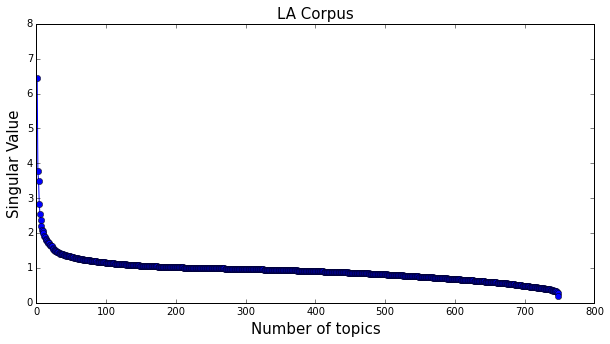

 
Top 20 Topics:
--------------
SV=6.458:  0.212*studio + 0.207*gym + 0.144*pilates + 0.139*massage + 0.129*instructors + 0.114*workout
SV=3.766: -0.798*massage - 0.310*thai - 0.140*masseuse + 0.133*gym - 0.110*spa - 0.106*therapist
SV=3.493:  0.487*gym - 0.265*studio + 0.221*machines + 0.181*locker + 0.171*pools - 0.170*pilates
SV=2.822: -0.511*pilates - 0.284*barre + 0.260*bikram - 0.187*reformer + 0.171*hot - 0.160*workout
SV=2.548:  0.471*barre - 0.463*pilates + 0.276*physique + 0.272*popped + 0.231*bar - 0.192*reformer
SV=2.372: -0.363*pilates - 0.341*bikram - 0.223*hot + 0.203*pole + 0.164*dancing - 0.147*reformer
SV=2.206:  0.584*pole + 0.346*dancing + 0.269*aerial + 0.174*silk + 0.133*zumba - 0.099*acupuncture
SV=2.073:  0.640*spin + 0.359*yas + 0.259*bike + 0.187*cycling + 0.162*flywheel - 0.162*pole
SV=2.047:  0.388*bikram - 0.301*store + 0.271*crossfit - 0.271*lululemon + 0.170*trainers - 0.162*lulu
SV=2.006: -0.388*store - 0.365*lululemon - 0.243*crossfit - 0.223*pants - 0.

In [40]:
'''
Check singular value calculation and plot singular values versus number of topics.
'''
sv    = lsi.projection.s
np_sv = np.linalg.svd(matutils.corpus2dense(corpus_lsi,ntops))
test  = np.sqrt(sum([(np_sv[1][i]-sv[i])**2 for i in range(len(sv))]))
print('Quadrature difference between singular value calculations = %f' % test)
    
fig, ax = plt.subplots( nrows=1, ncols=1, figsize=(10,5) )
ax.plot( range(1,len(sv)+1), sv, '-o' )
ax.set_xlabel( 'Number of topics', fontsize=15)
ax.set_ylim(0.0,8.0)
ax.set_ylabel( 'Singular Value', fontsize=15 )
ax.set_title( region+" Corpus", fontsize=15 )
plt.show()
# fig.savefig("nyc_singular_values.pdf")

nwords  = 6
ntopics = min(ntops,20)
print(" ")
print("Top %i Topics:" % ntopics)
print("--------------")
uv = lsi.projection.u
term_list = [i for i in range(len(dictionary))]
for jnd,vector in enumerate(zip(*uv)):
    out_string = "SV="+"{:.3f}".format(sv[jnd])+": "
    for ind,x in enumerate(sorted(zip(vector,term_list),key=lambda x: -abs(x[0]))[:nwords]):
        if x[0]>0.0:
            if ind>0:
                out_string += " + "+"{:.3f}".format(x[0])+"*"+stem_to_word[dictionary[x[1]]]
            else:
                out_string += " "+"{:.3f}".format(x[0])+"*"+stem_to_word[dictionary[x[1]]]
        else:
            if ind>0:
                out_string += " - "+"{:.3f}".format(abs(x[0]))+"*"+stem_to_word[dictionary[x[1]]]
            else:
                out_string += "-"+"{:.3f}".format(abs(x[0]))+"*"+stem_to_word[dictionary[x[1]]]
    print(out_string)
    if jnd == ntopics-1:
        break
    
#lsi.show_topics( num_topics=ntopics, num_words=nwords, log=False, formatted=True )

print(" ")
total_variance = sum([sv[i]**2 for i in range(len(sv))])
print("Total Variance = %f" %total_variance)

partial_variance = 0
old_explained_variance = 0
nonzero_sv = 0
for ind,value in enumerate(sv):
    if value != 0:
        nonzero_sv += 1
    partial_variance += value**2
    explained_variance = partial_variance/total_variance
    if old_explained_variance<0.70 and explained_variance >=0.70:
        print('Explained Variance = 70%% of total at Singular Value = %f (ranking %i).' %(value,ind+1))
    old_explained_variance = explained_variance
print('Number of non-zero singular values = %i.' % nonzero_sv)

In LA corpus:
* cpy is "Core Power Yoga"
* bar could be juice bar, or simply bar, or barely, barefoot,...
* yas refers to "Yoga And Spinning", a fitness center that provides both yoga classes and indoor cycling.